## CV Final Project: Interest Point Detector + Descriptor using SURF
Aja Klevs + Micaela Flores

In [121]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import time
import scipy
from PIL import Image
import math
import scipy.misc
from scipy.ndimage.interpolation import zoom
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pywt
from scipy import signal
from scipy.ndimage import gaussian_filter

import scipy.ndimage as ndimage #image processing library
import itertools

### Loading the Image

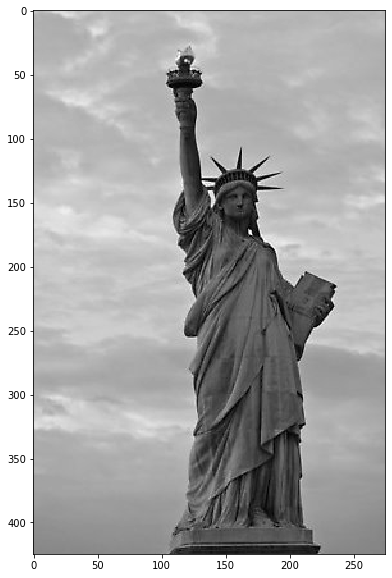

In [3]:
#loading and displaying base image, 'lady'

plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

name = 'lady_liberty1.jpeg'
lady = plt.imread(name)
lady = lady[25:450, 25:300]
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(lady)

### Creating Octaves

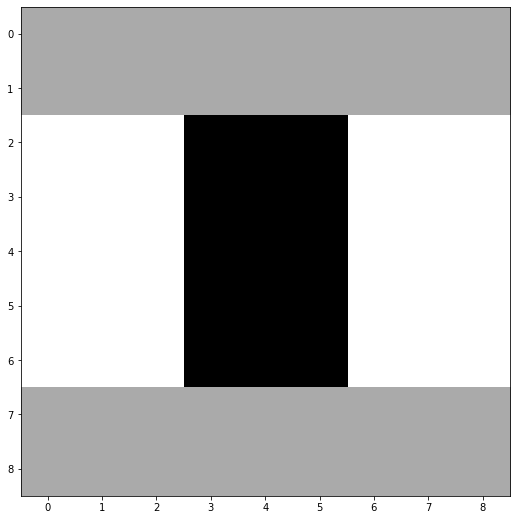

In [34]:
#functions to create block filters at different scales

def DxDy_filter(dim):
    mask = np.zeros((dim,dim))
    ref = int(math.ceil(dim/9))
    i1 = ref
    i2 = int(dim/3+(dim/3-3)/2+1)
    i3 = i2+1
    i4 = dim - ref
    
    mask[i1:i2, i1:i2] = 1
    mask[i3:i4, i3:i4] = 1
    mask[i1:i2, i3:i4] = -1
    mask[i3:i4, i1:i2] = -1
    
    return mask

def DyDy_filter(dim):
    mask = np.zeros((dim,dim))
    ref = int(dim/3)
    ref2 = math.floor(dim/2)
    i1 = ref
    i2 = 2*ref
    i3 = math.ceil(ref2/2)
    i4 = dim - math.ceil(ref2/2)
    
    mask[0:i1, i3:i4] = 1
    mask[i1:i2, i3:i4] = -2
    mask[i2:dim+1, i3:i4] = 1
    
    return mask

def DxDx_filter(dim):
    mask = np.zeros((dim,dim))
    ref = int(dim/3)
    ref2 = math.floor(dim/2)
    i1 = ref
    i2 = 2*ref
    i3 = math.ceil(ref2/2)
    i4 = dim - math.ceil(ref2/2)
    
    mask[i3:i4, 0:i1] = 1
    mask[i3:i4, i1:i2] = -2
    mask[i3:i4, i2:dim+1] = 1
    
    return mask

#visualizing a random block filter
test = DxDx_filter(9)
plt.figure(figsize=((9,9)))
plt.imshow(test)
plt.show()

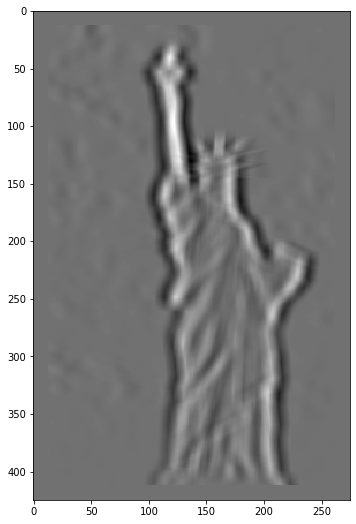

In [44]:
#We wrote our own convolve function, because scipy's convolve2d with mode set to 'valid' changes the size of
#the image.  it works okay but some of the indexing might be off, so we used convolve2d and inscribed it into
#a rectangle of zeros so that the convolutions would be the same size


def convolve(img,fltr):
    dim1,dim2 = fltr.shape
    half1,half2 = math.floor(dim1/2), math.floor(dim2/2)
    m,n = img.shape
    
    output = np.zeros((m,n))
    
    for i in np.arange(m-2*dim1)+dim1:
        for j in np.arange(n-2*dim2)+dim2:
            box = img[i-half1-1:i+half1, j-half2-1:j+half1]
            output[i][j] = np.sum(box*fltr)
            
    return output

def convolve_with_scipy(img, fltr):
    smaller_image = signal.convolve2d(img, fltr, mode = 'valid')
    height, width = np.array(img.shape) - np.array(smaller_image.shape)
    
    top = np.zeros((math.floor(height/2),smaller_image.shape[1]))
    bottom = np.zeros((math.ceil(height/2),smaller_image.shape[1]))
    
    left = np.zeros((img.shape[0], math.floor(width/2)))
    right = np.zeros((img.shape[0], math.ceil(width/2)))
    
    output = np.concatenate([top, smaller_image, bottom])
    output = np.concatenate([left, output, right], axis=1)
    
    return output

#testing the convolve2d filter
test = convolve_with_scipy(lady, DxDx_filter(27))
plt.figure(figsize=((9,9)))
plt.imshow(test)
plt.show()


In [45]:
#We implemented 2 octaves, the first has sigma values of 1.2, 2.4, 3.6, 4.8, 6.0, 7.2, 8.4, and 9.6
#corresponding to filters of size 9, 15, 21, 27, 33, 39, 45, and 51
#The second octave has sigma values of 4.4, 5.6, 6.8, 8.0, 9.2, 10.4, 11.6, and 12.8
#corresponding to filters of size 33,  45,  57,  69,  81,  93, 105, and 117

#at this step we represent each octave as a dictionary were keys are the numbers 1,2,3,4,5,6,7,8
#and the values are the convolved images at that scale.  the functions get_ss_first_octave and
#get_ss_second_octave give a list of s values corresponding the the keys of the octave

def create_first_octave(img, num_layers):
    layers = {}
    dims = np.linspace(9,9+6*(num_layers-1), num_layers)
    count = 0
    for di in dims:
        count += 1
        dim = int(di)
        Dxx = convolve_with_scipy(img, DxDx_filter(dim))
        Dxy = convolve_with_scipy(img, DxDy_filter(dim))
        Dyy = convolve_with_scipy(img, DyDy_filter(dim))
        
        this_scale = np.abs(Dxx*Dyy - ((.9**2)*Dxy*Dxy))
        s = ((dim - 9)/6 + 1)*1.2
        layers[count] = this_scale
    return layers

def create_second_octave(img, num_layers):
    layers = {}
    dims = np.linspace(33,33+12*(num_layers-1), num_layers)
    count = 0
    for di in dims:
        count += 1
        dim = int(di)
        Dxx = convolve_with_scipy(img, DxDx_filter(dim))
        Dxy = convolve_with_scipy(img, DxDy_filter(dim))
        Dyy = convolve_with_scipy(img, DyDy_filter(dim))
        
        this_scale = np.abs(Dxx*Dyy - ((.9**2)*Dxy*Dxy))
        s = ((dim - 9)/6 + 1)*1.2
        layers[count] = this_scale
    return layers

def get_ss_first_octave(num_layers):
    return np.linspace(1.2, 1.2*num_layers, num_layers)

def get_ss_second_octave(num_layers):
    return np.linspace(4.4, 1.6*num_layers, num_layers)
        

start_time = time.time()
first_octave = create_first_octave(lady, 8)
print('time to make first octave:', time.time() - start_time, 'seconds')
start_time = time.time()
second_octave = create_second_octave(lady, 8)
print('time to make second octave:' ,time.time() - start_time, 'seconds')
print('')
print('s (sigma) values for the first octave:')
print(get_ss_first_octave(8))
print('')
print('s (sigma) values for the second octave:')
print(get_ss_second_octave(8))

time to make first octave: 5.890613079071045 seconds
time to make second octave: 22.783793926239014 seconds

s (sigma) values for the first octave:
[1.2 2.4 3.6 4.8 6.  7.2 8.4 9.6]

s (sigma) values for the second octave:
[ 4.4  5.6  6.8  8.   9.2 10.4 11.6 12.8]


#################################
First Octave Convolved Images:
#################################


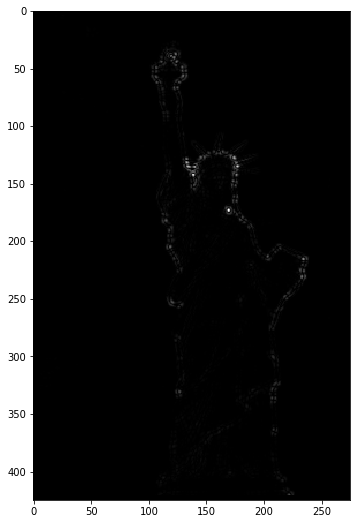

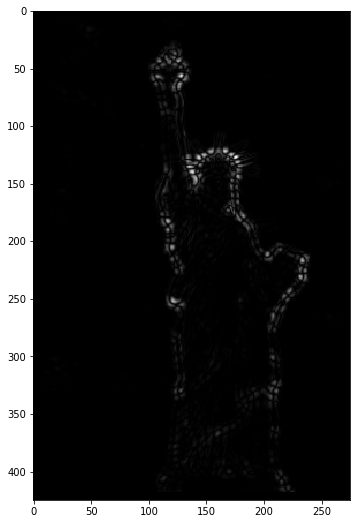

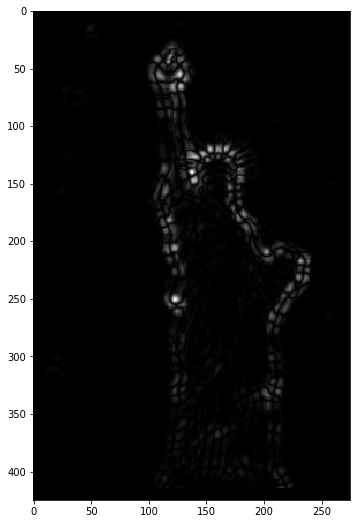

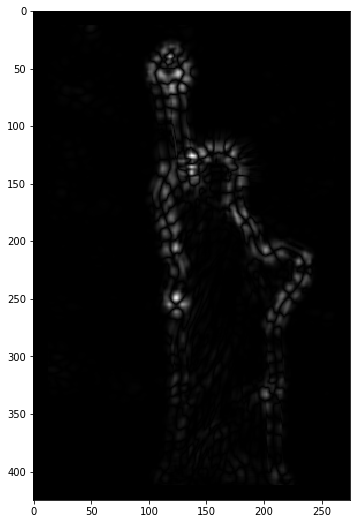

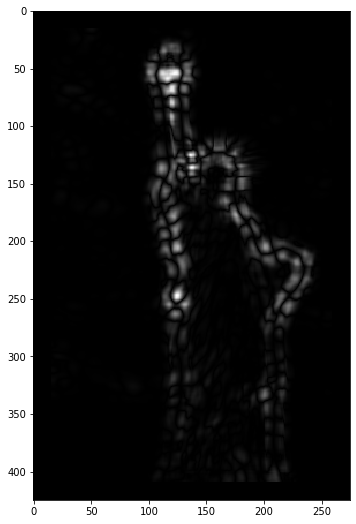

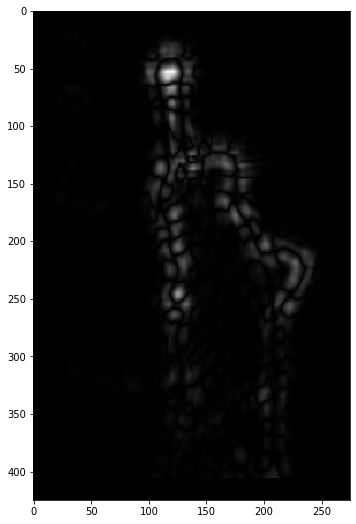

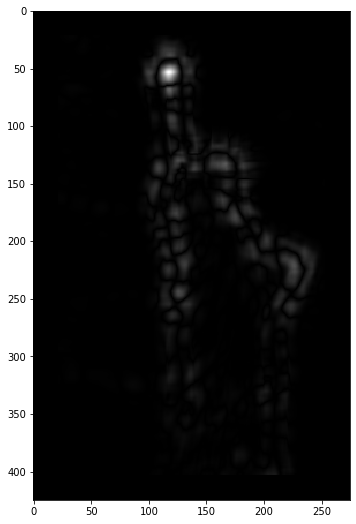

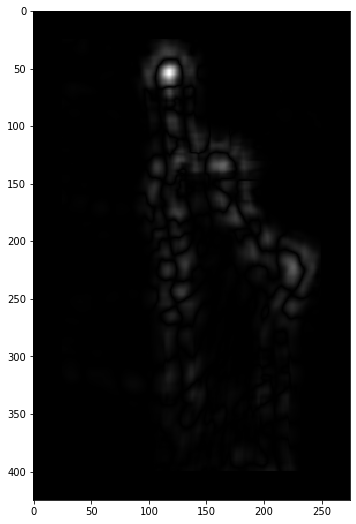

#################################
Second Octave Convolved Images:
#################################


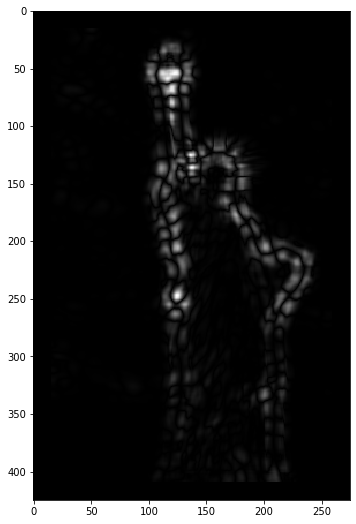

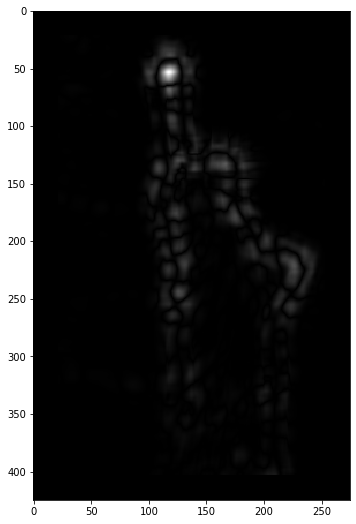

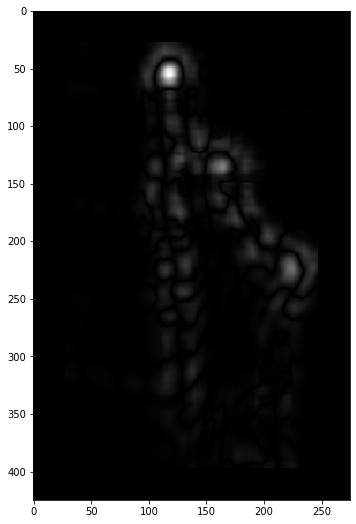

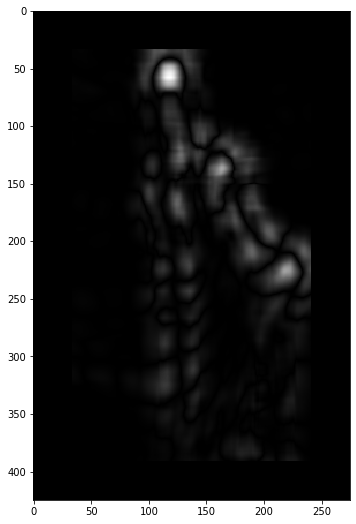

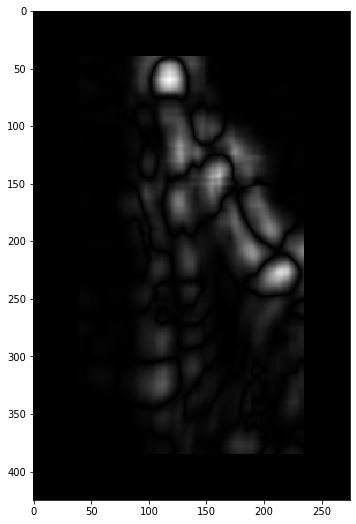

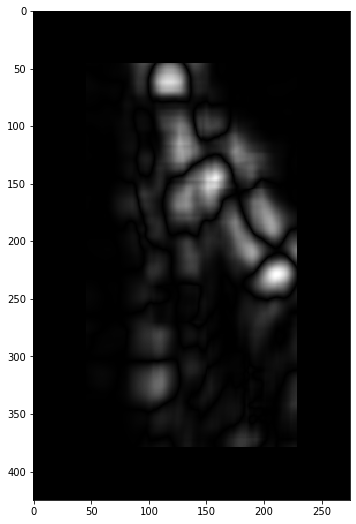

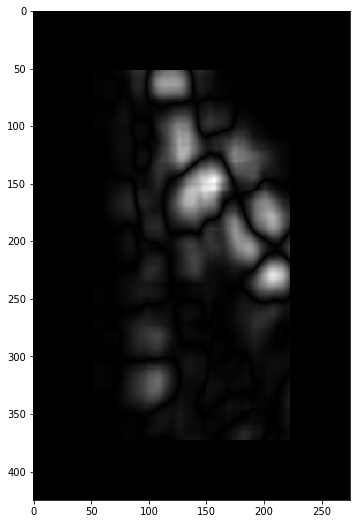

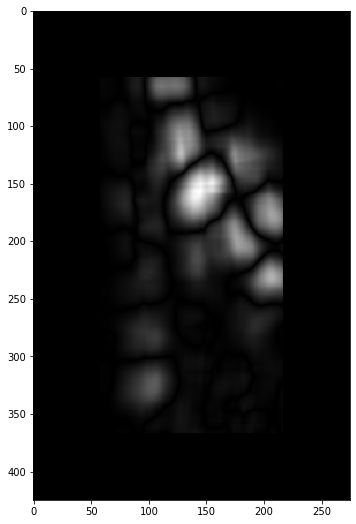

In [46]:
#visualizing each octave
print('#################################')
print('First Octave Convolved Images:')
print('#################################')
for layer in first_octave.keys():
    plt.figure(figsize=((9,9)))
    plt.imshow(first_octave[layer])
    plt.show()
print('#################################')
print('Second Octave Convolved Images:')
print('#################################')
for layer in second_octave.keys():
    plt.figure(figsize=((9,9)))
    plt.imshow(second_octave[layer])
    plt.show()
    

### Finding Interest Points

#################################
The thresholded layers of the first octave:
#################################


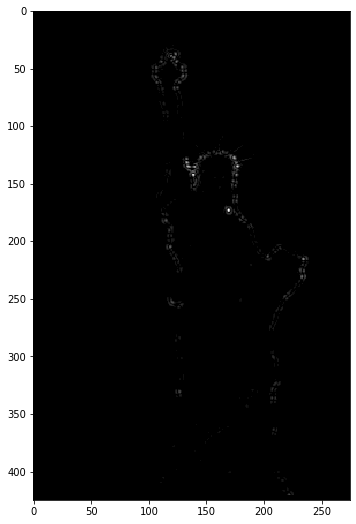

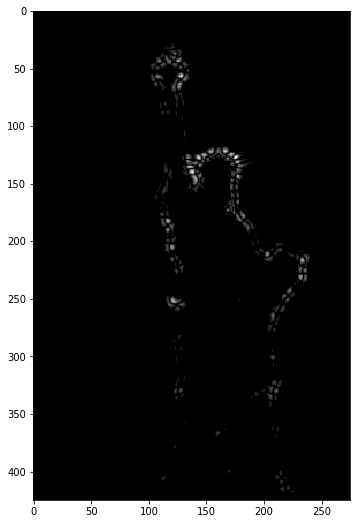

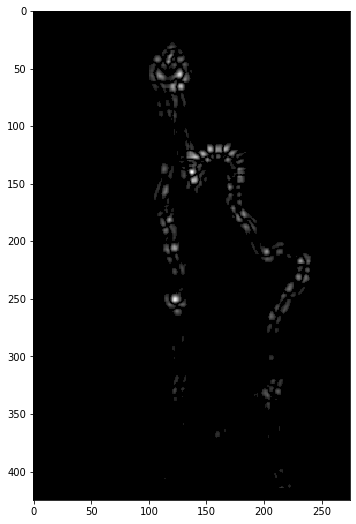

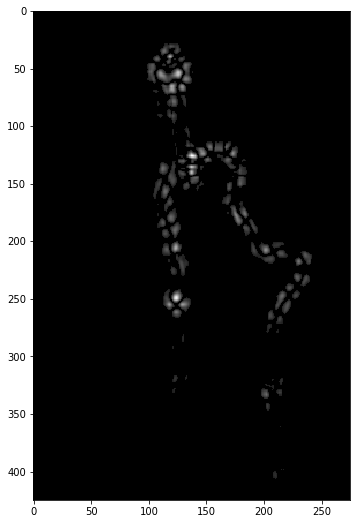

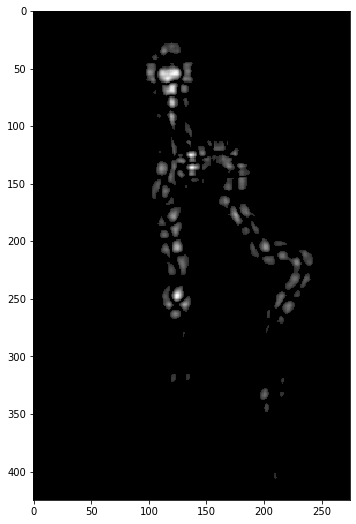

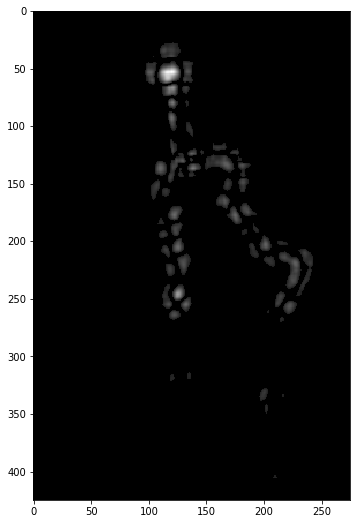

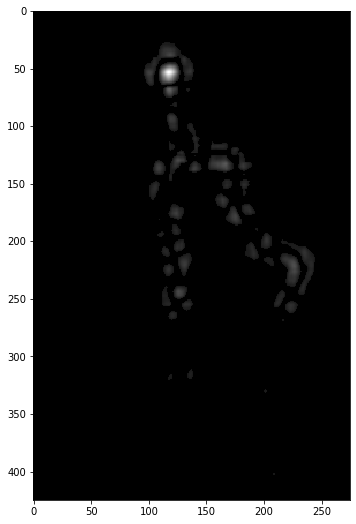

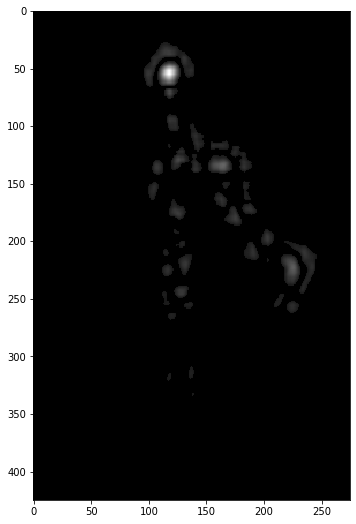

#################################
The thresholded layers of the second octave:
#################################


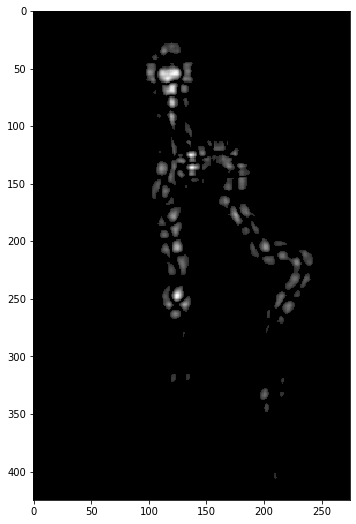

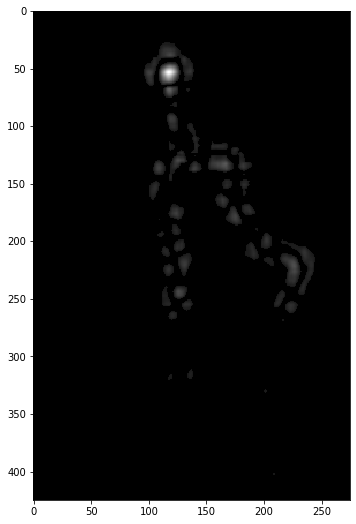

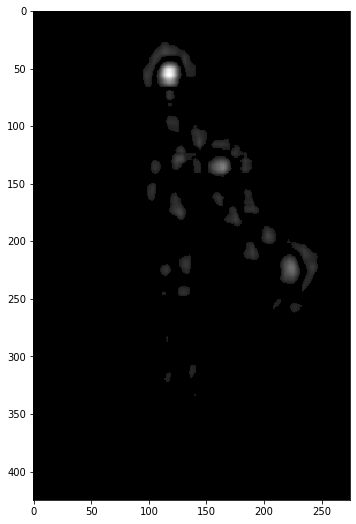

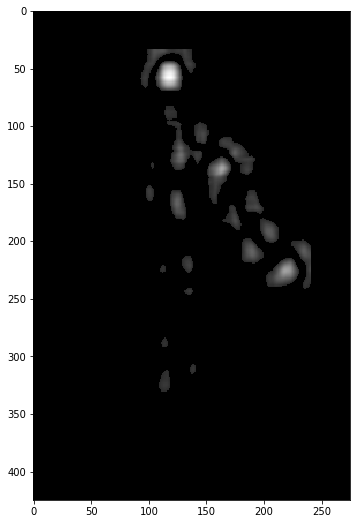

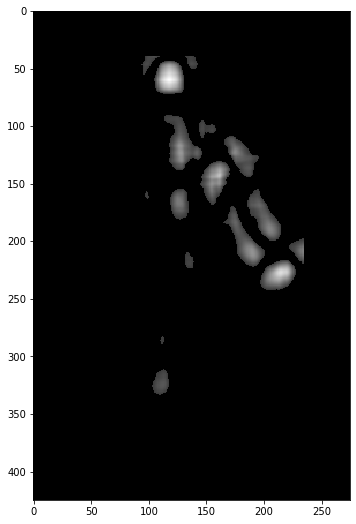

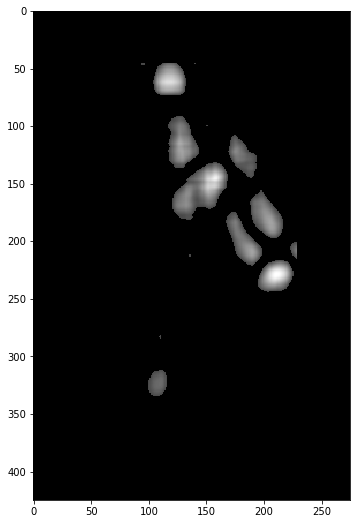

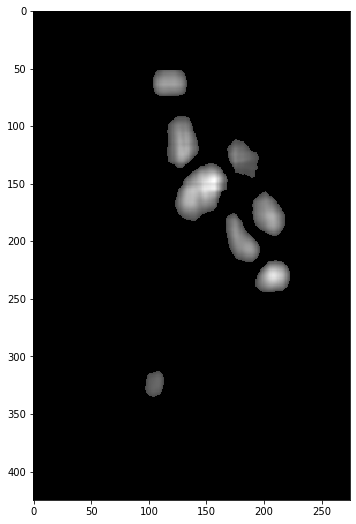

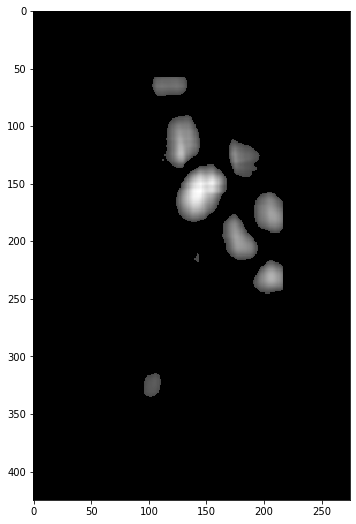

In [47]:
#threshold only keeps the points that are above 2 standard deviations of that layer
#of the octave.  Results are visualized below

def threshold(filtered_image):
    max_pixel = np.max(filtered_image)
    mean = np.mean(filtered_image)
    sd = np.std(filtered_image)
    mask = 1*(filtered_image > (mean + 2*sd))
    return mask*filtered_image

print('#################################')
print('The thresholded layers of the first octave:')
print('#################################')
thresholded_first_octave = {}
for layer in first_octave.keys():
    plt.figure(figsize=((9,9)))
    thresholded_first_octave[layer] = threshold(first_octave[layer])
    plt.imshow(thresholded_first_octave[layer])
    plt.show()
    
print('#################################')
print('The thresholded layers of the second octave:')
print('#################################')
thresholded_second_octave = {}
for layer in second_octave.keys():
    plt.figure(figsize=((9,9)))
    thresholded_second_octave[layer] = threshold(second_octave[layer])
    plt.imshow(thresholded_second_octave[layer])
    plt.show()

In [48]:
#This cell is functions we utilize to perform the max suppression

#returns the points in the 9x9x9 square that we will be using for mas suppression
def surround_pts(j,k,lyr):
    return [lyr[j-1][k-1],lyr[j-1][k],lyr[j-1][k+1],lyr[j][k-1],lyr[j][k+1],lyr[j+1][k-1],lyr[j+1][k],lyr[j+1][k+1]]


#fuction that returns true if the passed in point at (j,k) has the maximum value in its neighborhood
def check_point(j,k,previous_layer, current_layer, next_layer):
    this_point = current_layer[j][k]
    
    previous_pts = surround_pts(j,k,previous_layer)
    previous_pts.append(previous_layer[j][k])
    
    current_pts = surround_pts(j,k, current_layer)
    
    next_pts = surround_pts(j,k, next_layer)
    next_pts.append(next_layer[j][k])
    
    all_points = previous_pts + current_pts + next_pts
    
    for point in all_points:
        if this_point <= point:
            return False
    
    return True

#Function that performs the max suppression on an octave and returns the interest points in a dictionary
#where keys are the interest points and values are the corresponding s values
def find_interest_points(octave, first_or_second):
    num_layers = len(octave.keys())
    if first_or_second ==1:
        scales = get_ss_first_octave(num_layers)
    elif first_or_second ==2:
        scales = get_ss_second_octave(num_layers)
    interest_points = {}
    m,n = octave[1].shape
    for i in np.arange(num_layers-2)+2:
        previous_layer = octave[i-1]
        current_layer = octave[i]
        next_layer = octave[i+1]
    
        for j in np.arange(m-21)+10:
            for k in np.arange(n-21)+10:
                if check_point(j,k,previous_layer,current_layer,next_layer):
                    interest_points[(j,k)] = scales[i]
                    
    return interest_points

In [50]:
print('finding interest points in 1st octave...')
start_time = time.time()
first_octave_interest_points = find_interest_points(thresholded_first_octave, 1)
print('finding interest points took', time.time() - start_time, 'seconds')

print('')

print('finding interest points in 2st octave...')
start_time = time.time()
second_octave_interest_points = find_interest_points(thresholded_second_octave, 2)
print('finding interest points took', time.time() - start_time, 'seconds')

print('')

print('found', len(first_octave_interest_points.keys()), 'interest points in first octave and ', len(second_octave_interest_points.keys()), 'interest points in second octave')



finding interest points in 1st octave...
finding interest points took 8.758023262023926 seconds

finding interest points in 2st octave...
finding interest points took 8.541787147521973 seconds

found 158 interest points in first octave and  72 interest points in second octave


### Illustrating Interest Points

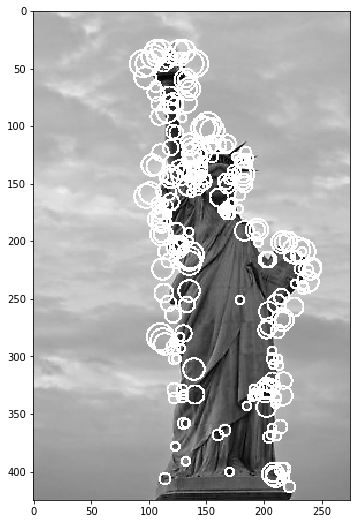

In [53]:
#function that draws a white circle of specified radius around the specified points
def illustrate_point(img, pt, radius):
    r = math.ceil(radius)
    output = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            output[i][j] = img[i][j]
    x,y = pt
    window = img[x-r-1:x+r+1, y-r-1:y+r+1]
    m,n = window.shape
    for i in np.linspace(x-r-1, x+r+1, x+r+1 - (x-r-1) + 1):
        for j in np.linspace(y-r-1, y+r+1, y+r+1 - (y-r-1) + 1):
            length = np.sqrt((i-x)**2 + (j - y)**2)
            if radius-1 < length < radius+1:
                output[int(i)][int(j)] = 255
                
    return output

#visualization of all our interest points circled by a radius of their "s"
copy = lady
for pt in first_octave_interest_points.keys():
    copy = illustrate_point(copy, pt, first_octave_interest_points[pt])
for pt in second_octave_interest_points.keys():
    copy = illustrate_point(copy, pt, second_octave_interest_points[pt])

plt.figure(figsize=((9,9)))
plt.imshow(copy)
plt.show()
        

### Finding Orientation

(212, 137)


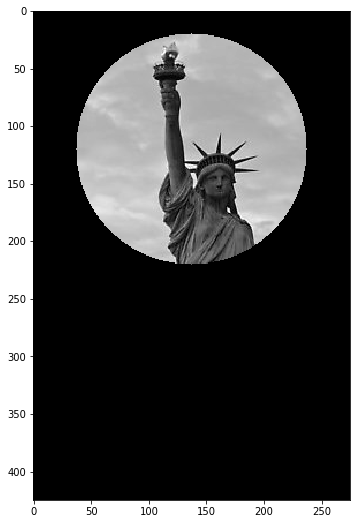

In [66]:
#function that creates a mask to zeros out everything not in the inner circle of specified radius
def circular_mask(shape, center, radius):
    h,w = shape
    X, Y = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    pts = list(zip(*np.where(mask != 0)))
    
    return mask, pts

#visualization of element-wise multiplication with the mask
print((math.floor(lady.shape[0]/2), math.floor(lady.shape[1]/2)))
mask = circular_mask(lady.shape, (120, math.floor(lady.shape[1]/2)), 100)[0]
plt.figure(figsize=((9,9)))
plt.imshow(lady*mask)
plt.show()

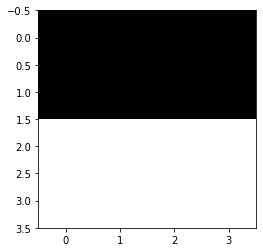

In [69]:
#function which creates haar wavelet filter with passed in dimenstion and orientation

def haar_wavelet_filter(dim, direction='x'):
    fltr = np.ones((dim,dim))
    halfway = dim//2
    
    if direction == 'x':
        #set -1 region
        fltr[:,0:halfway] = -1
    
    elif direction == 'y':
        #set -1 region
        fltr[0:halfway,:] = -1
    
    return fltr

#visualizing filter
plt.figure(figsize=((4,4)))
plt.imshow(haar_wavelet_filter(4,'y'))
plt.show()

In [58]:
#returns the square of "radius" half_length around the center
def square_around_pt(img, center, half_length):
    half_length = int(round(half_length))
    i,j = center
    square_img = img[i-half_length:i+half_length+1, j-half_length:j+half_length+1] 
    new_center = (square_img.shape[0]//2,square_img.shape[0]//2) #should be a square
    
    return square_img, new_center


#function that returns whether a point is in the specified sector, given start and end angle in polor coordinates
def in_sector(x, y, new_center, radius, start_angle, end_angle): #x is y and y is x
    x_c,y_c = new_center
    
    #the x coordinates are reversed in images, so switch the signs for the x differences only
    x_diff = -(x-x_c)
    
    # Calculate polar coordinates 
    p_radius = math.sqrt(x_diff**2 + (y-y_c)**2)
    p_angle = np.arctan2(x_diff, y-y_c) #technically y/x but we're dealing with an image

    #returns -pi to pi, so if negative, add 2pi
    if p_angle < 0: p_angle += 2*np.pi
        
    return (p_angle >= start_angle and p_angle < end_angle and p_radius <= radius)

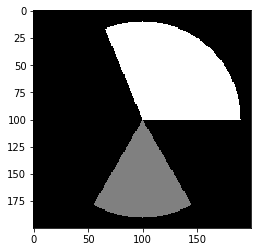

In [102]:
#function that returns whether a point is in the specified sector, given start and end angle in polor coordinates

def in_sector(x, y, new_center, radius, start_angle, end_angle): #x is y and y is x
    x_c,y_c = new_center
    
    #the x coordinates are reversed in images, so switch the signs for the x differences only
    x_diff = -(x-x_c)
    
    # Calculate polar coordinates 
    p_radius = math.sqrt(x_diff**2 + (y-y_c)**2)
    p_angle = np.arctan2(x_diff, y-y_c) #technically y/x but we're dealing with an image

    #returns -pi to pi, so if negative, add 2pi
    if p_angle < 0: p_angle += 2*np.pi
        
    return (p_angle >= start_angle and p_angle < end_angle and p_radius <= radius)


#visualization of in_sector
test = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        if in_sector(i,j,(100,100),90, -np.pi/2, 2.5*np.pi/4):
            test[i][j] = 1
            
        elif in_sector(i,j,(100,100),90, 4*np.pi/3, 5*np.pi/3):
            test[i][j] = .5
            
plt.figure(figsize=((4,4)))
plt.imshow(test)
plt.show()

In [84]:

'''
@description: this function takes in a circular region and and an initial orientation window and returns
              all the pixels within that scanning region within that orientation window
@params: circular_region - list of pixels that comprise the circular region of radius 6s around
                               an interest point
         x_grad, y_grad - first order gaussian derivatives after haar wavelet has already been convolved
@return: max_orientation - orientation that corresponds to the largest vector after summing the
                           x and y responses
'''
def scanning_orientation(circle, new_center, radius, dx, dy):
    pi = np.pi
    response_dict = {i:0 for i in range(8)}
    orientations = [pi/4, pi/2, 3*pi/4, pi, 5*pi/4, 3*pi/2, 7*pi/4, 0]
    response_map = {i:d for i,d in enumerate(orientations)}
    string_map = {0:'pi/4', 1:'pi/2', 2:'3pi/4', 3:'pi', 4:'5pi/4', 5:'3pi/2', 6:'5pi/4', 7:'2pi'}
    
    _,circular_pts = circular_mask(circle.shape,new_center,radius=radius) #square with mask + gaussian applied
    for pt in circular_pts:
        i,j = pt
        if in_sector(i,j, new_center, radius, pi/8, 3*pi/8): #(pi/8,3pi/8)
            response_dict[0] += dx[i][j] + dy[i][j] #do i need to make the x's negative here too?

        elif in_sector(i,j, new_center, radius, 3*pi/8, 5*pi/8): #(3pi/8,5pi/8)
            response_dict[1] += dx[i][j] + dy[i][j]

        elif in_sector(i,j, new_center, radius, 5*pi/8, 7*pi/8): #(5pi/8,7pi/8)
            response_dict[2] += dx[i][j] + dy[i][j]

        elif in_sector(i,j, new_center, radius, 7*pi/8, 9*pi/8): #(7pi/8,9pi/8)
            response_dict[3] += dx[i][j] + dy[i][j]

        elif in_sector(i,j, new_center, radius, 9*pi/8, 11*pi/8): #(9pi/8,11pi/8)
            response_dict[4] += dx[i][j] + dy[i][j]

        elif in_sector(i,j, new_center, radius, 11*pi/8, 13*pi/8): #(11pi/8,13pi/8)
            response_dict[5] += dx[i][j] + dy[i][j]
            
        elif in_sector(i,j, new_center, radius, 13*pi/8, 15*pi/8): #(13pi/8,15pi/8)
            response_dict[6] += dx[i][j] + dy[i][j]
            
        else: #(15pi/8,pi/8)
            response_dict[7] += dx[i][j] + dy[i][j]
    
    #print(response_dict)
    max_orientation = max(response_dict,key=response_dict.get)
    #print("max orientation key: ",max_orientation)
    
    return string_map[max_orientation]

#put whole process in one function
def orientation(img, interest_pt, scale):
    #get the square of length 6*s around the interest point + new center
    square, new_center = square_around_pt(img, center=interest_pt, half_length=6*scale)
    
    #apply gaussian to square
    square = ndimage.gaussian_filter(square, sigma=2.5*scale) #2.5s per the paper
    
    #apply the 15x15 circular mask to get the circle points only
    mask,_ = circular_mask(square.shape, new_center, radius=6*scale)
    circle = square*mask
    
    #create 4x4 haar wavelet filter in each direction
    hw_x = haar_wavelet_filter(4,'x') #4x4 just because
    hw_y = haar_wavelet_filter(4,'y')
    
    #apply haar wavelet filter to square in each direction
    dx = scipy.signal.convolve2d(circle, hw_x, 'same')
    dy = scipy.signal.convolve2d(circle, hw_y, 'same')

    #get the 8x8 circular mask to get the circle points only (note new radius below)
    small_mask,_ = circular_mask(circle.shape, new_center, radius=6*scale - 3.5)
    dx = dx*small_mask
    dy = dy*small_mask
    
    #scan over shifting region of pi/3 around the interest point and return the largest orientation
    max_orientation = scanning_orientation(circle, new_center, 6*scale-3.5, dx, dy)

    return max_orientation

In [105]:
#creating first first_octave_orientations and second_octave_orientations, where keys are the interest point
#and values are the orientations

print('finding orientations for first octave...')
start_time = time.time()
first_octave_orientations = {}
for interest_pt in first_octave_interest_points.keys():
    first_octave_orientations[interest_pt] = orientation(lady, interest_pt, first_octave_interest_points[interest_pt])
print('Orientations for first octave took', time.time() - start_time, 'seconds')

print('')

print('finding orientations for second octave...')
start_time = time.time()
second_octave_orientations = {}
for interest_pt in second_octave_interest_points.keys():
    second_octave_orientations[interest_pt] = orientation(lady, interest_pt, second_octave_interest_points[interest_pt])
print('Orientations for second octave took', time.time() - start_time, 'seconds')

finding orientations for first octave...
Orientations for first octave took 10.418355941772461 seconds

finding orientations for second octave...
Orientations for second octave took 8.321914196014404 seconds


### Getting Descripter

In [107]:
'''
@description: this function gets the points in a circular region around an interest point
@params: img - the image to get the circular points around
         center - the interest point around which to get the points
         scale - the scale s to multiply by 6 (radius = 6*s)
@return: circular_pts - list of tuples of the surrounding points in the circular region
'''
def get_circular_pts(img, center, scale):
    radius = 6*scale
    h,w = img.shape
    X, Y = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    circular_pts = list(zip(*np.where(mask != 0)))
    
    return circular_pts

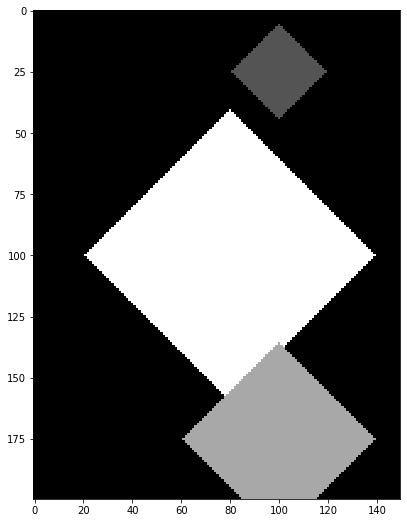

In [117]:
#finds distance of pt to the line spanned by the vector 'perpendicular'
def find_distance(pt, center, perpendicular):
    v1 = pt-center
    v2 = perpendicular
    factor = np.dot(v1,v2)/(np.linalg.norm(v2)**2)
    projection = v1 - factor*v2
    return np.linalg.norm(projection)

#finds points in the square rotated by pi/2 degress centered around center with 'radius' specified
def square_around_pt(img, center, radius):
    center = np.array(center)
    r = radius
    int_r = math.floor(r)
    adjusted_r = math.floor(r/np.sqrt(2))
    circle = get_circular_pts(img, center, r)
    output = []
    
    perpendicular = np.array([1,-1])
    parallel = np.array([-1,-1])
    for pt in circle:
        d1 = find_distance(np.array(pt), center, perpendicular)
        d2 = find_distance(np.array(pt), center, parallel)
        if d1 < adjusted_r and d2 < adjusted_r:
            output.append(pt)   
    
    return np.array(output)

#Visualization of square_around_pt
test = np.zeros((200,150))
region1 = square_around_pt(test,(100,80),60)
region2 = square_around_pt(test, (25,100), 20)
region3 = square_around_pt(test, (175,100), 40)
        
for pt in region1:
    test[pt[0]][pt[1]] = 1
    
for pt in region2:
    test[pt[0]][pt[1]] = .33
    
for pt in region3:
    test[pt[0]][pt[1]] = .66
    
plt.figure(figsize=((9,9)))
plt.imshow(test)
plt.show() 

In [118]:
#helper function which returns the 16 centers of the descriptor blocks, according to the passed in orientation
def get_descriptor_centers(img, center, orientation, s):
    i,j = center
    box_dim = 4*s/np.sqrt(2)
    up1 = math.ceil(box_dim)
    up2 = math.ceil(2*box_dim)
    up3 = math.ceil(3*box_dim)
    
    centers = {}
    if orientation == '7pi/4':
        centers[4] = (i + up3,j)
        centers[3] = (i + up2, j+up1)
        centers[2] = (i + up1, j+up2)
        centers[1] = (i, j+ up3)
        
        centers[8] = (i + up2, j-up1)
        centers[7] = (i + up1, j)
        centers[6] = (i, j+up1)
        centers[5] = (i - up1, j+ up2)
        
        centers[12] = (i + up1, j - up2)
        centers[11] = (i, j-up1)
        centers[10] = (i - up1, j)
        centers[9] = (i - up2, j+up1)
        
        centers[13] = (i,j-up3)
        centers[14] = (i - up1, j-up2)
        centers[15] = (i -up2, j-up1)
        centers[16] = (i - up3, j)
        
    elif orientation == '5pi/4':
        centers[4] = (i,j - up3)
        centers[3] = (i +up1, j-up2)
        centers[2] = (i + up2, j-up1)
        centers[1] = (i + up3, j)
        
        centers[8] = (i - up1, j-up2)
        centers[7] = (i, j - up1)
        centers[6] = (i+up1, j)
        centers[5] = (i + up2, j+ up1)
        
        centers[12] = (i - up2, j - up1)
        centers[11] = (i-up1, j)
        centers[10] = (i, j+ up1)
        centers[9] = (i + up1, j+up2)
        
        centers[16] = (i - up3 ,j)
        centers[15] = (i - up2, j+ up1)
        centers[14] = (i -up1, j+up2)
        centers[13] = (i, j+up3)
        
    elif orientation == '3pi/4':
        centers[13] = (i + up3,j)
        centers[14] = (i + up2, j+up1)
        centers[15] = (i + up1, j+up2)
        centers[16] = (i, j+ up3)
        
        centers[9] = (i + up2, j-up1)
        centers[10] = (i + up1, j)
        centers[11] = (i, j+up1)
        centers[12] = (i - up1, j+ up2)
        
        centers[5] = (i + up1, j - up2)
        centers[6] = (i, j-up1)
        centers[7] = (i - up1, j)
        centers[8] = (i - up2, j+up1)
        
        centers[1] = (i,j-up3)
        centers[2] = (i - up1, j-up2)
        centers[3] = (i -up2, j-up1)
        centers[4] = (i - up3, j)
        
    elif orientation == 'pi/4':
        centers[13] = (i,j - up3)
        centers[14] = (i +up1, j-up2)
        centers[15] = (i + up2, j-up1)
        centers[16] = (i + up3, j)
        
        centers[9] = (i - up1, j-up2)
        centers[10] = (i, j - up1)
        centers[11] = (i+up1, j)
        centers[12] = (i + up2, j+ up1)
        
        centers[5] = (i - up2, j - up1)
        centers[6] = (i-up1, j)
        centers[7] = (i, j+ up1)
        centers[8] = (i + up1, j+up2)
        
        centers[1] = (i - up3 ,j)
        centers[2] = (i - up2, j+up1)
        centers[3] = (i -up1, j+up2)
        centers[4] = (i, j+up3)
    return centers
        

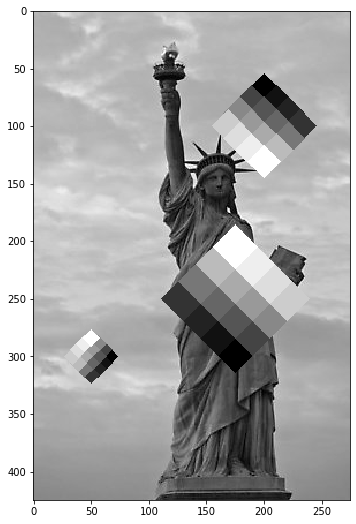

In [120]:
#visualization of get_descriptor_centers combined with square_around_pt

s=3.6
centers = get_descriptor_centers(lady, (100,200), 'pi/4', s)

colors = np.linspace(0,255, 16)

copy = np.ones(copy.shape)
for i in range(copy.shape[0]):
    for j in range(copy.shape[1]):
        copy[i][j] = lady[i][j]
            
for i in np.arange(16)+1:
    square = square_around_pt(copy, centers[i], 4*s)
    for pt in square:
        copy[pt[0]][pt[1]] = colors[i-1]
        
s=1.8
centers = get_descriptor_centers(lady, (300,50), '7pi/4', s)
             
for i in np.arange(16)+1:
    square = square_around_pt(copy, centers[i], 4*s)
    for pt in square:
        copy[pt[0]][pt[1]] = colors[i-1]
        
s=5.2
centers = get_descriptor_centers(lady, (250,175), '5pi/4', s)
            
for i in np.arange(16)+1:
    square = square_around_pt(copy, centers[i], 4*s)
    for pt in square:
        copy[pt[0]][pt[1]] = colors[i-1]
    
plt.figure(figsize=((9,9)))
plt.imshow(copy)
plt.show()   
    

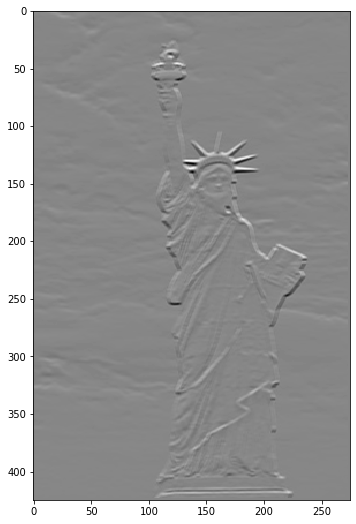

In [123]:
#getting image ready
lady_dx = convolve_with_scipy(lady, haar_wavelet_filter(4, direction='x'))
lady_dy = convolve_with_scipy(lady, haar_wavelet_filter(4, direction='y'))

plt.figure(figsize=((9,9)))
plt.imshow(lady_dy)
plt.show()

In [147]:
def get_straight_blocks(img, interest_pt, s, orientation):
    i,j = interest_pt
    
    up1 = math.ceil(5*s)
    up2 = math.ceil(10*s)
    
    blocks = {}
    
    blocks[4] = img[i+up1:i+up2 , j+up1: j+up2]
    blocks[3] = img[i:i+up1 , j+up1: j+up2]
    blocks[2] = img[i-up1:i , j+up1: j+up2]
    blocks[1] = img[i-up2:i-up1 , j+up1:j+up2]
    
    blocks[8] = img[i+up1:i+up2 , j: j+up1]
    blocks[7] = img[i:i+up1 , j: j+up1]
    blocks[6] = img[i-up1:i , j: j+up1]
    blocks[5] = img[i-up2:i-up1 , j: j+up1]
    
    blocks[12] = img[i+up1:i+up2, j-up1: j]
    blocks[11] = img[i:i+up1 , j-up1: j]
    blocks[10] = img[i-up1:i , j-up1: j]
    blocks[9] = img[i-up2:i-up1 , j-up1: j]

    blocks[16] = img[i+up1:i+up2, j-up2: j-up1]
    blocks[15] = img[i:i+up1 , j-up2: j-up1]
    blocks[14] = img[i-up1:i , j-up2: j-up1]
    blocks[13] = img[i-up2:i-up1 , j-up2: j-up1]
    
    output = {}
    
    if orientation == '2pi':
        output = blocks
    elif orientation == 'pi/2':
        output[1] = blocks[13]
        output[2] = blocks[9]
        output[3] = blocks[5]
        output[4] = blocks[1]
        
        output[5] = blocks[14]
        output[6] = blocks[10]
        output[7] = blocks[6]
        output[8] = blocks[2]
        
        output[9] = blocks[15]
        output[10] = blocks[11]
        output[11] = blocks[7]
        output[12] = blocks[3]
        
        output[13] = blocks[16]
        output[14] = blocks[12]
        output[15] = blocks[8]
        output[16] = blocks[4]
        
    elif orientation == 'pi':
        output[1] = blocks[16]
        output[2] = blocks[15]
        output[3] = blocks[14]
        output[4] = blocks[13]

        output[5] = blocks[12]
        output[6] = blocks[11]
        output[7] = blocks[10]
        output[8] = blocks[9]

        output[9] = blocks[8]
        output[10] = blocks[7]
        output[11] = blocks[6]
        output[12] = blocks[5]

        output[13] = blocks[4]
        output[14] = blocks[3]
        output[15] = blocks[2]
        output[16] = blocks[1]
        
    elif orientation == '3pi/2':
        output[1] = blocks[4]
        output[2] = blocks[8]
        output[3] = blocks[12]
        output[4] = blocks[16]
        
        output[5] = blocks[3]
        output[6] = blocks[7]
        output[7] = blocks[11]
        output[8] = blocks[15]
        
        output[9] = blocks[2]
        output[10] = blocks[6]
        output[11] = blocks[10]
        output[12] = blocks[14]
        
        output[13] = blocks[1]
        output[14] = blocks[5]
        output[15] = blocks[9]
        output[16] = blocks[13]
        
        
    return output
        

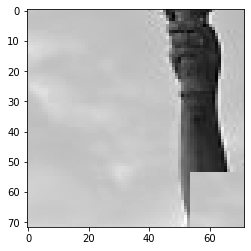

In [151]:
s=3.6
blocks = get_straight_blocks(lady, (100,100), 3.6, 'pi/2')

row1 = np.concatenate([blocks[1],blocks[2], blocks[3], blocks[4]], axis=1)
row2 = np.concatenate([blocks[5],blocks[6], blocks[7], blocks[8]], axis=1)
row3 = np.concatenate([blocks[9],blocks[10], blocks[11], blocks[12]], axis=1)
row4 = np.concatenate([blocks[13],blocks[14], blocks[15], blocks[6]], axis=1)

test = np.concatenate([row1,row2,row3,row4])
    
    
plt.figure(figsize=((4,4)))
plt.imshow(test)
plt.show()

In [129]:

def get_descriptor(img_dx, img_dy, interest_pt, s, orientation):
    i,j = interest_pt
    descriptor = []
    if orientation == 'pi/4' or orientation == '3pi/4' or orientation == '5pi/4' or orientation == '7pi/4':
        centers = get_descriptor_centers(lady_dx, (i,j), orientation, s)
        for i in np.arange(16)+1:
            dx_sum = 0
            dy_sum = 0
            dx_abs_sum = 0
            dy_abs_sum = 0
            block = square_around_pt(copy, centers[i], 4*s)
            for pt in block:
                dx_value = img_dx[pt[0]][pt[1]]
                dy_value = img_dy[pt[0]][pt[1]]
                dx_sum += dx_value
                dy_sum += dy_value
                dx_abs_sum += np.abs(dx_value)
                dy_abs_sum += np.abs(dy_value)
            
            descriptor += [dx_sum, dy_sum, dx_abs_sum, dy_abs_sum]
    
    elif:
            
    return np.array(descriptor)
                
        

get_descriptor(lady_dx, lady_dy, (100,100), 3.6, 'pi/4')      

array([ 20676.,  -6514.,  25994.,  14318.,  50371., -11065.,  58971.,
        31005.,  -6749.,  -7909.,  89247.,  23999., -47074.,   5046.,
        63742.,  14138.,   1263.,  -1157.,   3393.,   4195.,   2260.,
        -1354.,   5528.,   5958.,  48537.,  -1201.,  54661.,  10413.,
         5672.,   5280.,  87126.,  14874.,   2011.,  -2255.,   4973.,
         8523.,   -346.,    238.,   3994.,   7898.,   3281.,   -509.,
         7467.,   6299.,  40383.,  -7189.,  46427.,  10145.,  -1450.,
         3934.,   5472.,   8314.,   -482.,   -890.,   3392.,   6114.,
          154.,   -938.,   5416.,   6900.,  -2569.,  -4581.,   4367.,
         7765.])